In [1]:
import numpy as np
import time
import pandas as pd
%matplotlib inline
import joblib
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets, model_selection
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
import warnings
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [ ]:
'''
Authors:
Andrea Pimpinella <andrea.pimpinella@polimi.it>,
Antonio Capone  <antonio.capone@polimi.it>

This code preprocesses raw data and perform features extraction for
Prediction Model of Video Quality Long Term QoE use case.
'''

In [2]:
#USEFUL FUNCTIONS FOR PLOTTING

def plot_cdf(data, votes, bin_edges, ax, xlabel=None, color=None, plot_flag = 0):
    '''
    This function is useful to understand whether the input feature "data" has
    information that is correlated to the
    satisfaction of the users.
    Generally speaking, the meaning of the CDFs is: if there is a gap between
    the distributions of the data conditioned to the satisfaction class of the
    corresponding users, it means that the information in the data is correlated
    to users satisfaction and thus can be learnt by a supervised classifier.
    Generally speaking, looking at data distributions is the first step to
    decide whether some data may be useful or not for ML problems.
    :param data: data to be plot (one-dimensional array)
    :param votes: satisfaction labels, int; if already binary, set threshold to None
    :param bin_edges: array of type  np.linspace(min(data), max(data), num_bins+1)
    :param ax: axis of type plt.subplots(figsize=(a,b));
    :param xlabel: label to give to x axis
    :param color: axis color
    :return: gap between satisfied and unsatisfied user CDFs
    '''

    if xlabel is None:
        xlabel = 'your data'
    if color is None:
        color = 'black'

    yt = votes.copy()

    neg, _ = np.histogram(data[yt == +1], bins=bin_edges)  # count number of evidences per bin
    pos, _ = np.histogram(data[yt == 0], bins=bin_edges)

    sumpos =  sum(pos)
    sumneg =  sum(neg)
    pos = pos.astype(float) / sumpos  # normalize to total number of evidences
    neg = neg.astype(float) / sumneg

    xrange = bin_edges[1:] - bin_edges[:1]
    if plot_flag == 0:
      title = 'CDF'
      ax.plot(xrange, np.cumsum(pos))
      ax.plot(xrange, np.cumsum(neg))
      ax.xaxis.label.set_color(color)
      ax.yaxis.label.set_color(color)
      ax.tick_params(axis='x', colors=color)
      ax.tick_params(axis='y', colors=color)
      ax.xaxis.grid(True)
      ax.yaxis.grid(True)
      ax.set_xlabel(xlabel)
      ax.set_title(title, color=color)
      ax.legend(['High QoE', 'Low QoE'])

    # Calculate the gap between the CDFs
    gap = np.abs(np.cumsum(pos) - np.cumsum(neg)).max()

    return gap

# Import Training Data

In [3]:
if 'dataset' in globals():
    del dataset
if 'ground_truth' in globals():
    del ground_truth

# Load the Training Set
path = '/content/' # PUT YOUR FILE PATH
basic_train = pd.read_csv(path+'BasicDataset_Training_MRN.csv')

dataset = basic_train.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
ground_truth = basic_train.loc[:, 'User_Satisfaction'].copy()
print('Train Data:', dataset.shape)
print('Train Target:', ground_truth.shape)
print('% of Class 1 Users (Dissatisfied) in Training : ', len(dataset[ground_truth == 1]) / len(dataset),
      '\n% of Class 0 Users (Satisfied) in Training: ', len(dataset[ground_truth == 0]) / len(dataset))



Train Data: (18970, 12)
Train Target: (18970,)
% of Class 1 Users (Dissatisfied) in Training :  0.3274644175013179 
% of Class 0 Users (Satisfied) in Training:  0.6725355824986822


In [4]:
#print(list(dataset.columns))
dataset.head()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
0,100.727,110854.0,0.000,0.0,-6.0,27.8,53917,5636,2043,213227,3996,2883
1,9.324,93.0,0.000,0.0,-3.0,-19.8,85021,1761,1223,87700,4287,1251
2,2715.406,2271118.0,580.907,63891.0,-3.0,-19.8,123462,4664,2715,203846,5776,8748
3,74.097,39065.0,0.000,0.0,-4.0,-19.8,85675,4903,1322,7924,1799,9491
4,168.955,41933.0,0.000,0.0,-3.0,-19.9,104902,2068,669,137121,3846,937


In [5]:
print(ground_truth.value_counts())
ground_truth.head()

0.0    12758
1.0     6212
Name: User_Satisfaction, dtype: int64


0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: User_Satisfaction, dtype: float64

In [6]:
# Import test data

test_file = '/content/BasicDataset_Test_MRN.csv'
test_df = pd.read_csv(test_file)
test_dataset = test_df.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
test_ground_truth = test_df.loc[:, 'User_Satisfaction'].copy()

In [7]:
print(test_dataset.shape)
print(40*"-")
print("The number of NaN values per each feature is: \n" + str(test_dataset.isnull().sum()))
print(40*"-")
test_dataset.head()

(4743, 12)
----------------------------------------
The number of NaN values per each feature is: 
Cumulative_YoutubeSess_LTE_DL_Time       0
Cumulative_YoutubeSess_LTE_DL_Volume     0
Cumulative_YoutubeSess_UMTS_DL_Time      0
Cumulative_YoutubeSess_UMTS_DL_Volume    0
Max_RSRQ                                 0
Max_SNR                                  0
Cumulative_Full_Service_Time_UMTS        0
Cumulative_Lim_Service_Time_UMTS         0
Cumulative_No_Service_Time_UMTS          0
Cumulative_Full_Service_Time_LTE         0
Cumulative_Lim_Service_Time_LTE          0
Cumulative_No_Service_Time_LTE           0
dtype: int64
----------------------------------------


,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
0,8.518,78.0,0.000,0.0,-3.0,23.2,57563,7008,1426,233812,4604,7976
1,1006.045,199826.0,55.468,9946.0,-3.0,-19.8,93171,3051,674,235586,1524,8292
2,529.336,862215.0,157.434,59074.0,-6.0,26.6,99831,3154,4817,134049,2576,1970
3,98.740,28225.0,0.000,0.0,-7.0,24.6,58229,1947,4566,152322,4369,4964
4,3179.844,2055606.0,86.741,22218.0,-6.0,23.4,107891,5672,1048,138108,4236,3183


In [8]:
print(test_ground_truth.value_counts())
test_ground_truth.head()

0.0    3221
1.0    1522
Name: User_Satisfaction, dtype: int64


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: User_Satisfaction, dtype: float64

In [ ]:
'''
Features:

'Cumulative_YoutubeSess_LTE_DL_Time': The cumulative time spent by a user in the last 30 days under 3g  connection, restricted to youtube application.
'Cumulative_YoutubeSess_LTE_DL_Volume': The cumulative traffic volume downloaded by a user in the last 30 days under 3g connection, restricted to youtube application.

'Cumulative_YoutubeSess_UMTS_DL_Time': The cumulative time spent by a user in the last 30 days under 4g  connection, restricted to youtube application.
'Cumulative_YoutubeSess_UMTS_DL_Volume': The cumulative traffic volume downloaded by a user in the last 30 days under 4g connection, restricted to youtube application.

'Max_RSRQ': Max RSRQ reported by the user's terminal in the last 30 days.
'Max_SNR': Max SNR reported by the user's terminal in the last 30 days.

'Cumulative_Full_Service_Time_UMTS': The cumulative time spent by a user in the last 30 days under 3g full service.
'Cumulative_Lim_Service_Time_UMTS': The cumulative time spent by a user in the last 30 days under 3g limmied service.
'Cumulative_No_Service_Time_UMTS': The cumulative time spent by a user in the last 30 days under 3g no service.

'Cumulative_Full_Service_Time_LTE' The cumulative time spent by a user in the last 30 days under 4g full service.
'Cumulative_Lim_Service_Time_LTE': The cumulative time spent by a user in the last 30 days under 4g limmited service.
'Cumulative_No_Service_Time_LTE': The cumulative time spent by a user in the last 30 days under 4g no service.
'''

# Data Visualization

In [ ]:
# Here Plot and PreProcess data for a first overview and preliminary analysis

In [9]:
dataset.describe()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
count,18970.000000,1.897000e+04,18970.000000,1.897000e+04,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000
mean,487.266447,2.440304e+05,110.665139,2.232142e+04,-5.307433,9.883853,72252.154296,3752.604006,1872.484555,158112.288508,2908.896679,5258.542910
std,1449.015098,6.374373e+05,624.233314,1.355857e+05,1.669185,21.491851,31227.745075,2295.803530,1187.075427,70135.668569,1672.653145,3592.832064
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-15.000000,-20.000000,3.000000,1.000000,0.000000,40.000000,0.000000,0.000000
25%,11.369250,5.140000e+02,0.000000,0.000000e+00,-7.000000,-19.800000,52438.250000,1974.000000,945.000000,120955.000000,1545.000000,2346.000000
50%,79.409000,3.361850e+04,0.000000,0.000000e+00,-6.000000,23.000000,74205.000000,3552.000000,1677.000000,162095.500000,2864.000000,4579.000000
75%,370.633000,1.920348e+05,20.027750,2.370500e+03,-4.000000,27.800000,92469.500000,5082.750000,2712.500000,206388.500000,4156.000000,8018.000000
max,53176.133000,1.158222e+07,22973.810000,5.024200e+06,-3.000000,29.800000,149980.000000,9999.000000,4998.000000,299988.000000,6997.000000,14999.000000


In [10]:
def plot_multiple_cdfs_sorted(dataset, ground_truth, data_features, plots_per_row=3, plot_flag=0):
    num_features = len(data_features)

    # Calculate the number of rows and columns based on the number of features and plots_per_row
    num_rows = (num_features + plots_per_row - 1) // plots_per_row
    num_cols = min(num_features, plots_per_row)

    # Calculate the figure size based on the number of rows and columns
    fig_width = 5 * num_cols
    fig_height = 5 * num_rows

    if plot_flag == 0:
        # Create a new plot using plt.subplots and set the figure size
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    gaps = {}  # Dictionary to store the gaps for each feature

    for i, feature in enumerate(data_features):
        data = dataset[feature].values

        # Check for invalid values (NaN or Inf)
        if np.isnan(data).any() or np.isinf(data).any():
            # Handle the case of invalid values (e.g., skip plotting)
            continue

        # Generate example satisfaction labels (0 for unsatisfied, 1 for satisfied)
        votes = ground_truth.astype(str).str[0].astype(int).values

        # Define the bin edges for the CDF plot
        bin_edges = np.linspace(min(data), max(data), 101)

        if plot_flag == 0:
            # Call the plot_cdf function with the data and other parameters
            gap = plot_cdf(data, votes, bin_edges, axes[i // num_cols, i % num_cols], xlabel='Feature', color='green', plot_flag=plot_flag)
            axes[i // num_cols, i % num_cols].set_title('CDF for {}'.format(feature))
        else:
            gap = plot_cdf(data, votes, bin_edges, None, plot_flag=plot_flag)

        # Store the gap in the dictionary with the feature name as the key
        gaps[feature] = gap

    # Sort the data features based on the gap in descending order
    sorted_features = sorted(gaps.items(), key=lambda x: x[1], reverse=True)

    if plot_flag == 0:
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        plt.show()

    # Return the sorted features list
    return sorted_features



In [92]:
## First Task: KPI Analysis
## The following function is used to visualize how the data is distributed
## and how the user QoE impacts it


def plot_histograms_satisfied_vs_dissatisfied(dataset, ground_truth):


    x_ranges = {

        'Cumulative_YoutubeSess_LTE_DL_Time': (0, 800),
        #'Cumulative_YoutubeSess_LTE_DL_Volume': (0.0, 1.0),
        'Cumulative_YoutubeSess_UMTS_DL_Time': (0, 800),
        #'Cumulative_YoutubeSess_UMTS_DL_Volume': (0, 2),
        'Max_RSRQ': (-10, -2)
    }

    y_ranges = {
        'Cumulative_YoutubeSess_LTE_DL_Time': (0, 750),
        'Cumulative_YoutubeSess_LTE_DL_Volume': (0, 1600),
        'Cumulative_YoutubeSess_UMTS_DL_Time': (0, 750),
        'Cumulative_YoutubeSess_UMTS_DL_Volume': (0, 750),
    }

    for feature in dataset.columns:
        satisfied_data = dataset.loc[ground_truth.values == 1, feature]
        dissatisfied_data = dataset.loc[ground_truth.values == 0, feature]

        if feature in x_ranges:
            x_min, x_max = x_ranges[feature]
        else:
            x_min = min(min(satisfied_data), min(dissatisfied_data))
            x_max = max(max(satisfied_data), max(dissatisfied_data))

        use_custom_y_range = False
        if feature in y_ranges:
            y_min, y_max = y_ranges[feature]
            use_custom_y_range = True

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].hist(satisfied_data, bins=200, color='green', alpha=0.7, range=(x_min, x_max))
        axes[0].set_title('Satisfied Users')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Frequency')
        if use_custom_y_range:
            axes[0].set_ylim(y_min, y_max)  # Set the y-axis limit here

        axes[1].hist(dissatisfied_data, bins=200, color='red', alpha=0.7, range=(x_min, x_max))
        axes[1].set_title('Dissatisfied Users')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Frequency')
        if use_custom_y_range:
            axes[1].set_ylim(y_min, y_max)  # Set the y-axis limit here

        plt.tight_layout()
        plt.show()


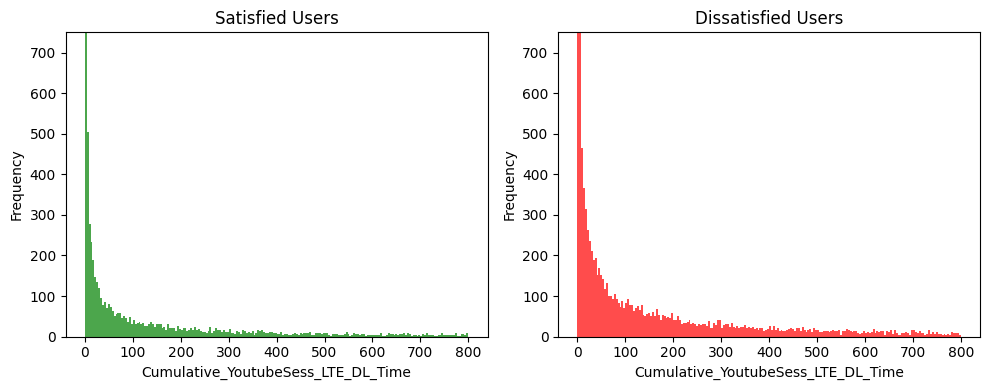

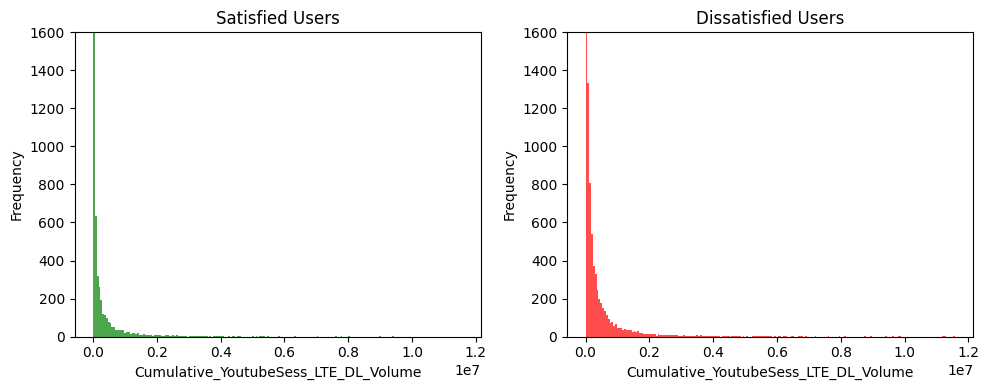

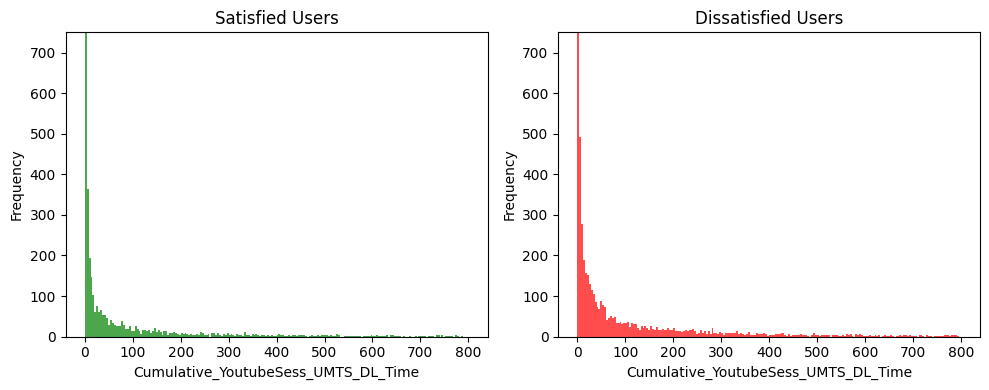

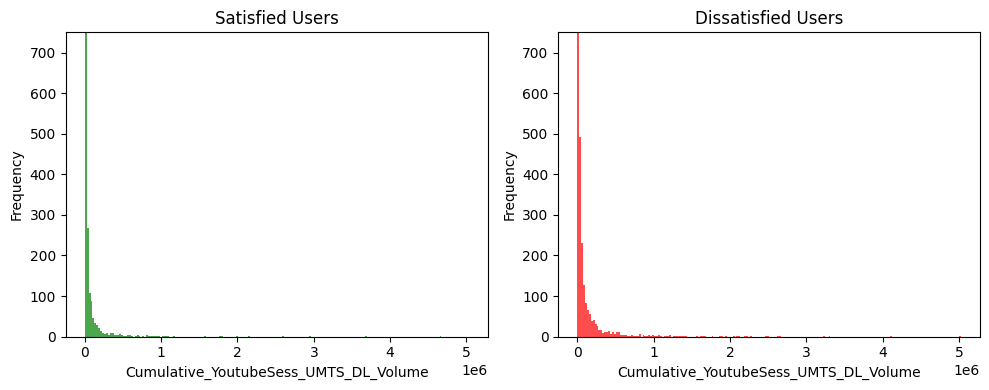

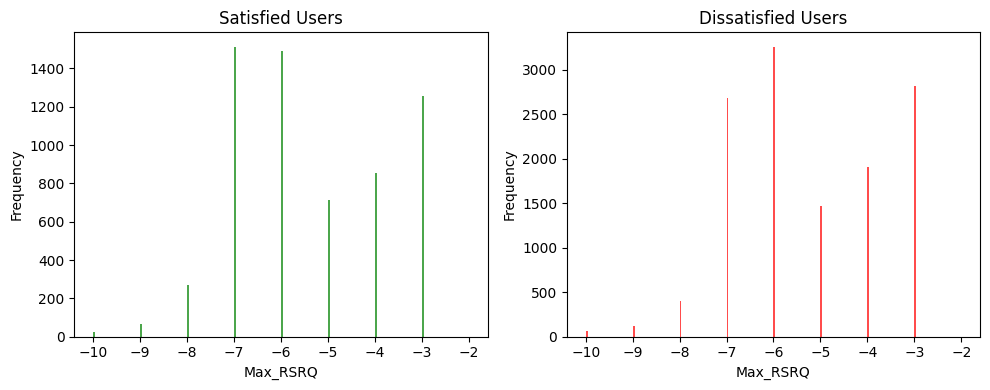

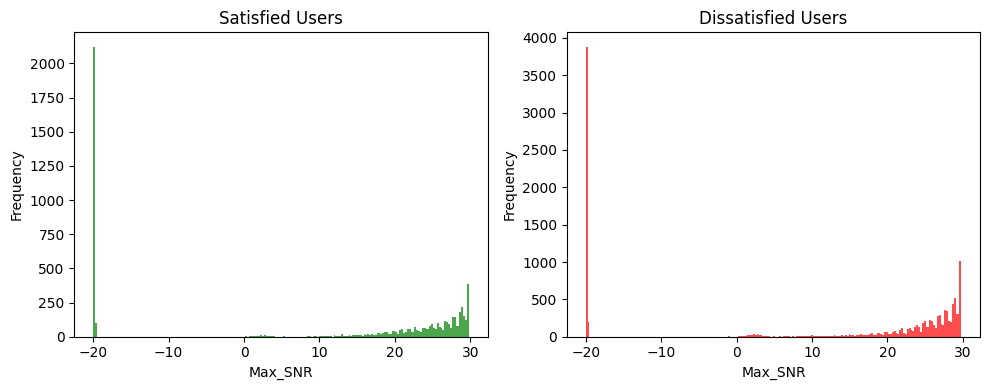

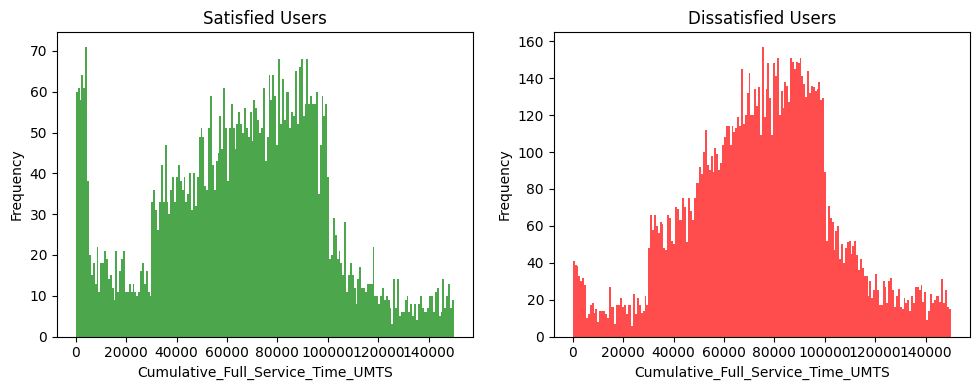

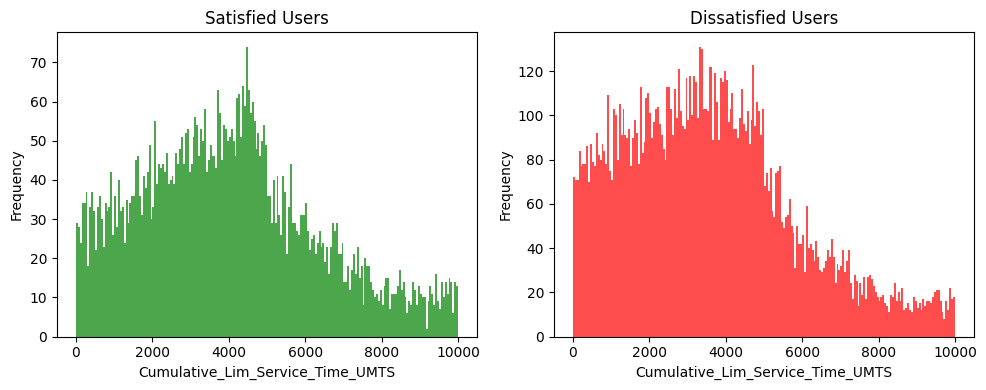

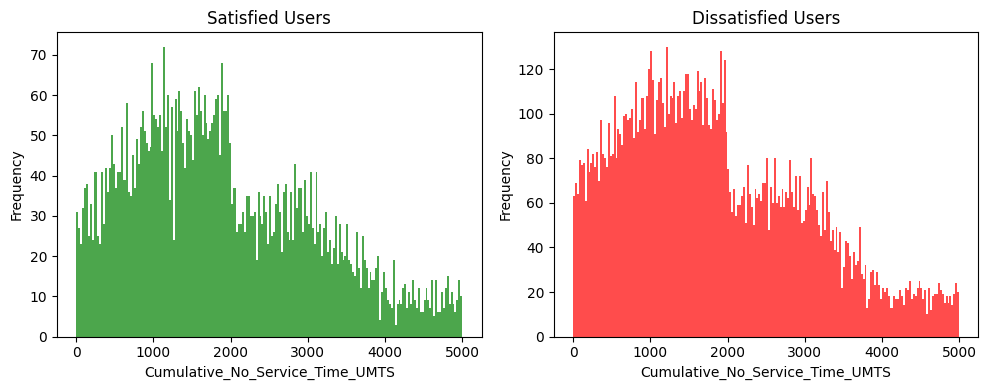

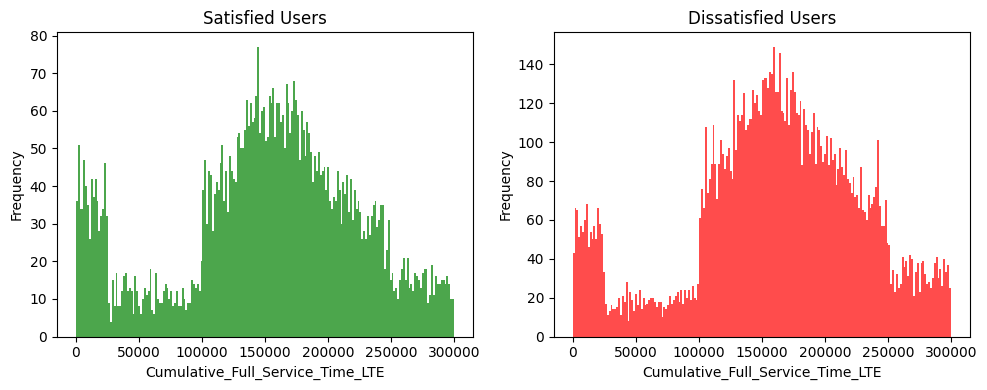

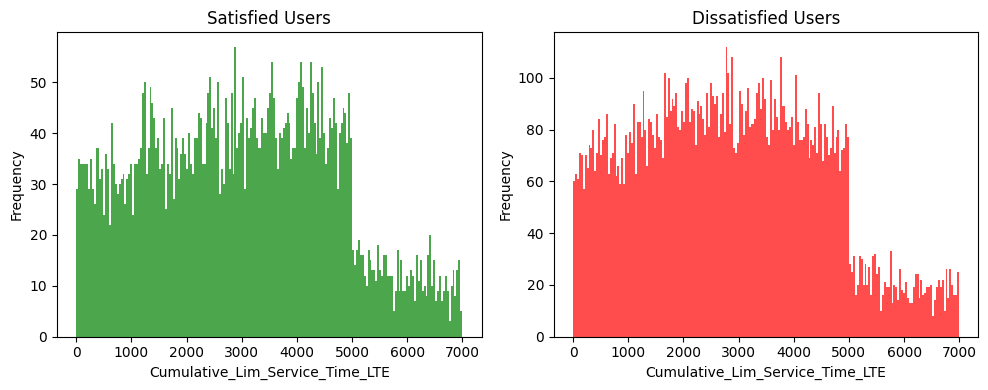

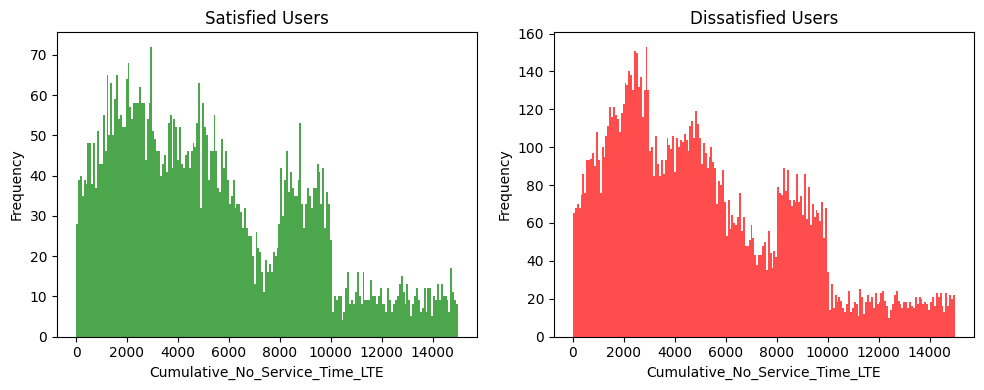

In [93]:
plot_histograms_satisfied_vs_dissatisfied(dataset, ground_truth)

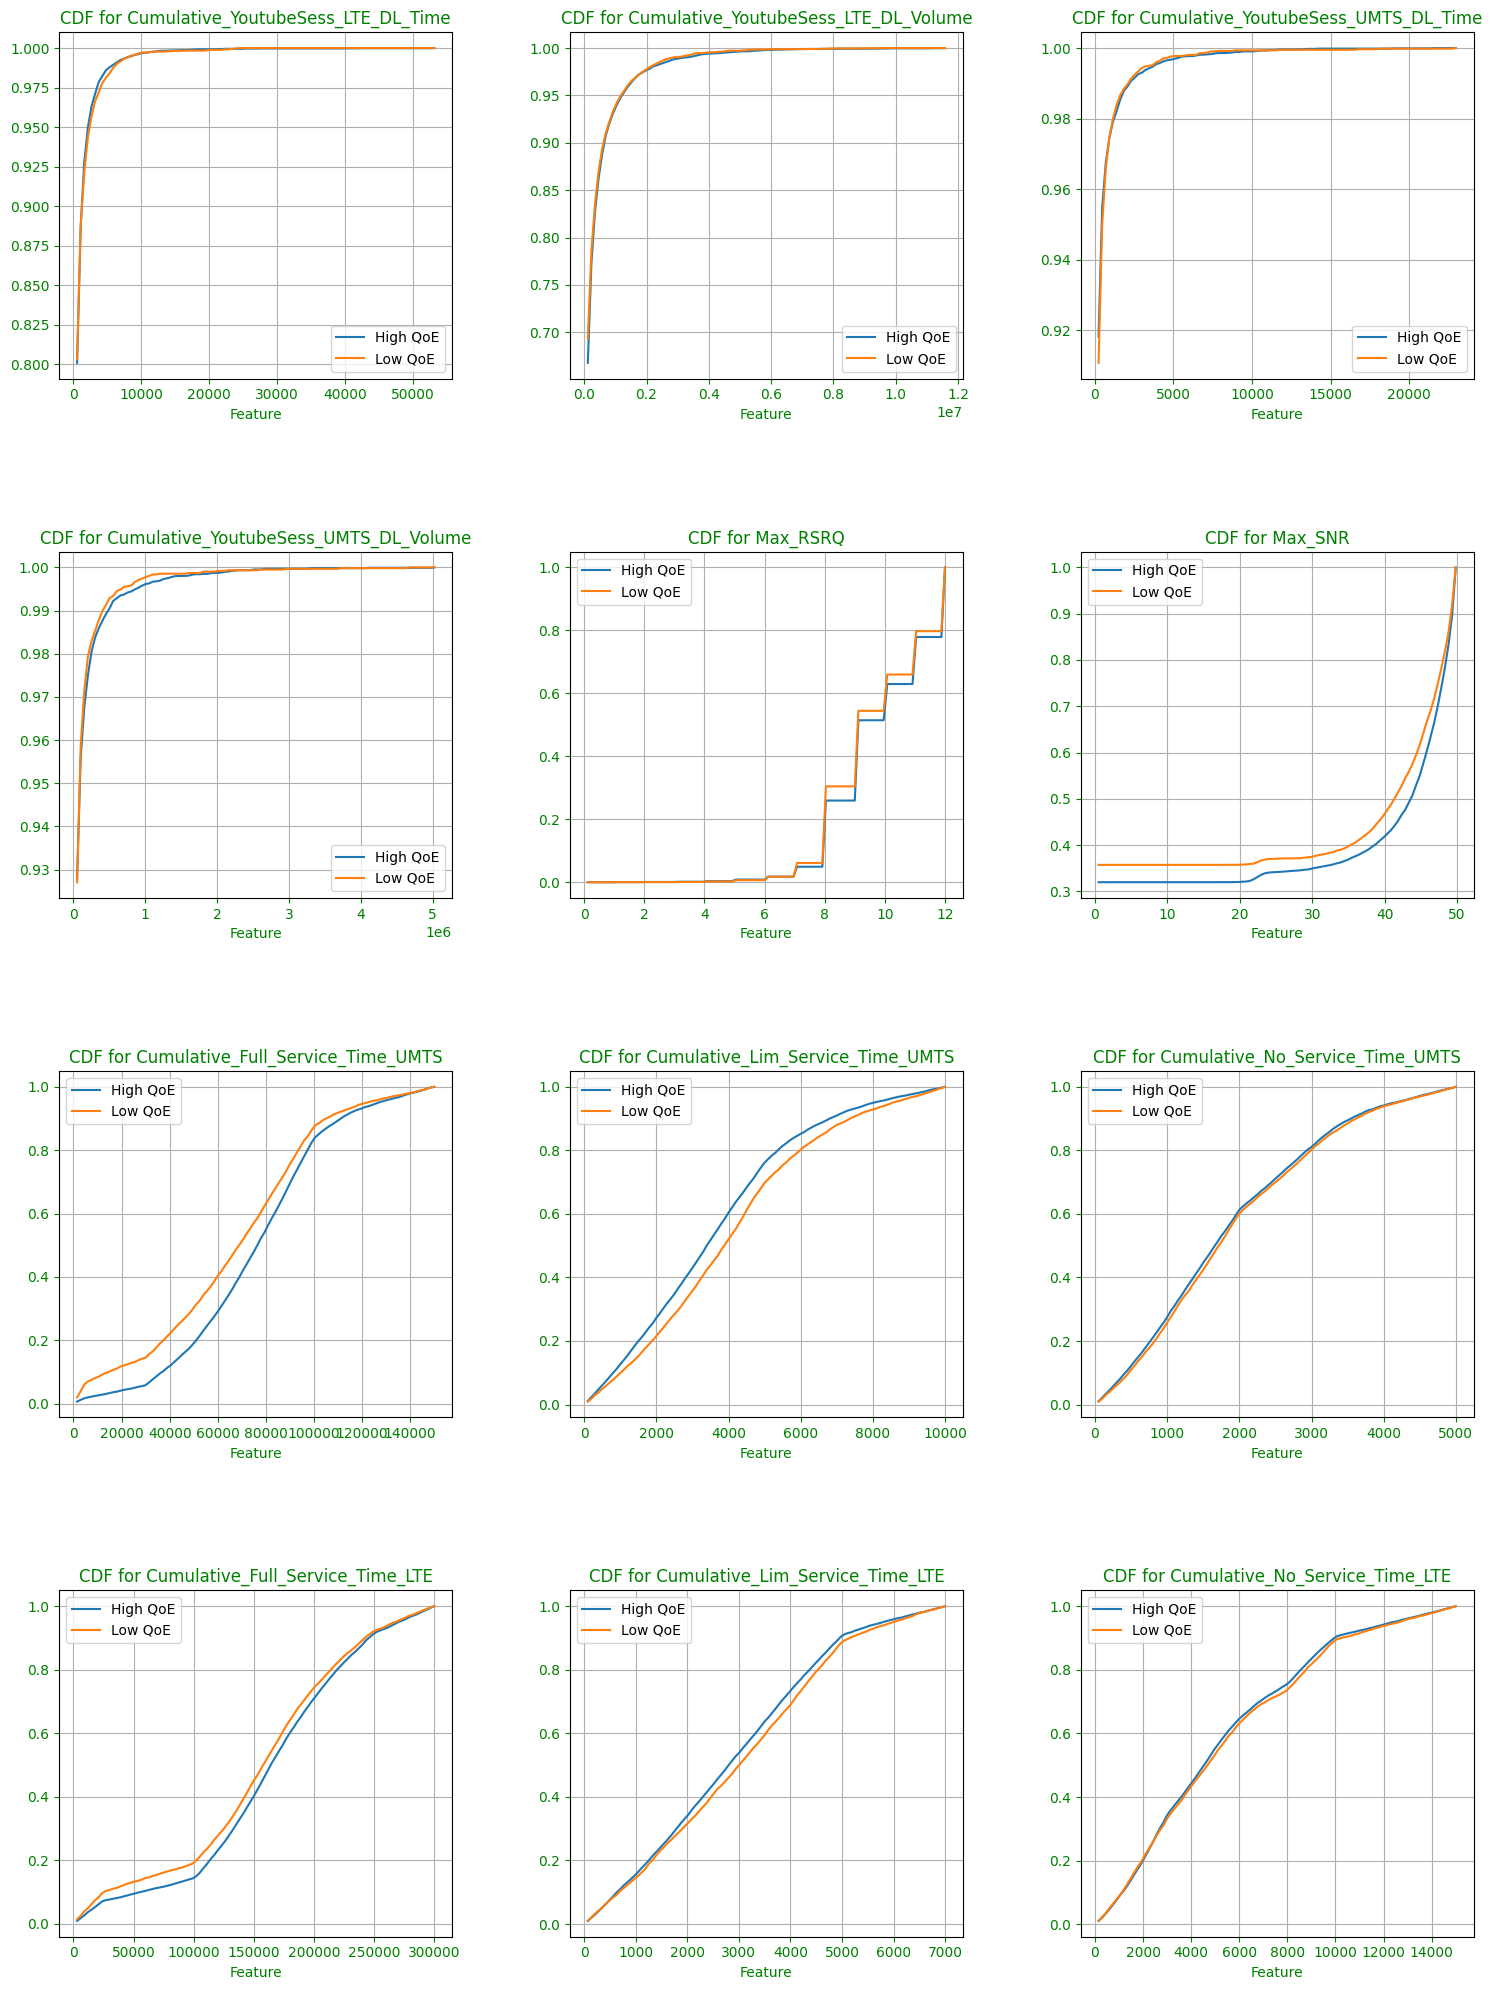

----------------------------------------
Features sorted by the gap between satisfied and unsatisfied user CDFs:
- Cumulative_Full_Service_Time_UMTS : 0.1136
- Cumulative_Lim_Service_Time_UMTS : 0.0852
- Max_SNR : 0.0683
- Cumulative_Full_Service_Time_LTE : 0.0507
- Max_RSRQ : 0.0451
- Cumulative_Lim_Service_Time_LTE : 0.0443
- Cumulative_YoutubeSess_LTE_DL_Volume : 0.0257
- Cumulative_No_Service_Time_UMTS : 0.0225
- Cumulative_No_Service_Time_LTE : 0.0197
- Cumulative_YoutubeSess_UMTS_DL_Time : 0.0074
- Cumulative_YoutubeSess_LTE_DL_Time : 0.0065
- Cumulative_YoutubeSess_UMTS_DL_Volume : 0.0044


In [ ]:
data_features = ['Cumulative_YoutubeSess_LTE_DL_Time',
       'Cumulative_YoutubeSess_LTE_DL_Volume',
       'Cumulative_YoutubeSess_UMTS_DL_Time',
       'Cumulative_YoutubeSess_UMTS_DL_Volume', 'Max_RSRQ', 'Max_SNR',
       'Cumulative_Full_Service_Time_UMTS', 'Cumulative_Lim_Service_Time_UMTS',
       'Cumulative_No_Service_Time_UMTS', 'Cumulative_Full_Service_Time_LTE',
       'Cumulative_Lim_Service_Time_LTE', 'Cumulative_No_Service_Time_LTE']

sorted_features = plot_multiple_cdfs_sorted(dataset, ground_truth, data_features)

# Print the features based on the biggest gap to the lowest gap
print(40*"-")
print("Features sorted by the gap between satisfied and unsatisfied user CDFs:")
for feature, gap in sorted_features:
    formatted_gap = "{:.4f}".format(gap)
    print("- {} : {}".format(feature, formatted_gap))



# Features Engineering

In [ ]:
# Here create new features: transform basic features (if needed), create new features, exclude unnecessary
# features (i.e., those which are not correlated with target), etc.

# Visual Tools: Conditional CDFs with respect to user lables, Conditional Pair-Wise ScatterPlots, etc.
# Mathematical Tools: Mathematical Ttransformations, Features-Target Correlation Analysis, etc.

In [ ]:
#### Creating New Features in the Feature Engineering part and test them to see if they are informative or not.

def create_engineered_dataset(dataset_name, dataset, output_suffix):
    engineered_dataset = pd.DataFrame()

    # Cumulative YouTube Time and Volume Averages for UMTS and LTE
    engineered_dataset['Avg_Youtube_Time_UMTS'] = dataset['Cumulative_YoutubeSess_UMTS_DL_Time'] / 30
    engineered_dataset['Avg_Youtube_Volume_UMTS'] = dataset['Cumulative_YoutubeSess_UMTS_DL_Volume'] / 30
    engineered_dataset['Avg_Youtube_Time_LTE'] = dataset['Cumulative_YoutubeSess_LTE_DL_Time'] / 30
    engineered_dataset['Avg_Youtube_Volume_LTE'] = dataset['Cumulative_YoutubeSess_LTE_DL_Volume'] / 30


    # Service Availability Ratios for UMTS and LTE
    engineered_dataset['Service_Availability_Ratio_UMTS'] = (dataset['Cumulative_Full_Service_Time_UMTS'] / 30) / (
      dataset['Cumulative_Lim_Service_Time_UMTS'] / 30 + dataset['Cumulative_No_Service_Time_UMTS'] / 30
    )
    engineered_dataset['Service_Availability_Ratio_LTE'] = (dataset['Cumulative_Full_Service_Time_LTE'] / 30) / (
      dataset['Cumulative_Lim_Service_Time_LTE'] / 30 + dataset['Cumulative_No_Service_Time_LTE'] / 30
    )

    # Total Service Time for UMTS and LTE
    engineered_dataset['Total_Service_Time_UMTS'] = (
        dataset['Cumulative_Full_Service_Time_UMTS'] / 30
        + dataset['Cumulative_Lim_Service_Time_UMTS'] / 30
        + dataset['Cumulative_No_Service_Time_UMTS'] / 30
    )
    engineered_dataset['Total_Service_Time_LTE'] = (
        dataset['Cumulative_Full_Service_Time_LTE'] / 30
        + dataset['Cumulative_Lim_Service_Time_LTE'] / 30
        + dataset['Cumulative_No_Service_Time_LTE'] / 30
    )

    # YouTube Time Percentage for UMTS and LTE
    engineered_dataset['Youtube_Time_Percentage_UMTS'] = (
        engineered_dataset['Avg_Youtube_Time_UMTS'] / engineered_dataset['Total_Service_Time_UMTS']
    ) * 100
    engineered_dataset['Youtube_Time_Percentage_LTE'] = (
        engineered_dataset['Avg_Youtube_Time_LTE'] / engineered_dataset['Total_Service_Time_LTE']
    ) * 100

    # Network Type Preference
    engineered_dataset['Preferred_Network_Type'] = (
        engineered_dataset['Total_Service_Time_LTE'] > engineered_dataset['Total_Service_Time_UMTS']
    ).astype(int)

    print(f"new dataset shape: {engineered_dataset.shape}")
    print(40*"-")
    print("The number of NaN values per each feature is: \n" + str(engineered_dataset.isnull().sum()))
    print(40*"-")
    return engineered_dataset

In [ ]:
dataset_name = "dataset"
output_suffix = "2"
dataset2 = create_engineered_dataset(dataset_name, dataset, output_suffix)

new dataset shape: (18970, 11)
----------------------------------------
The number of NaN values per each feature is: 
Avg_Youtube_Time_UMTS              0
Avg_Youtube_Volume_UMTS            0
Avg_Youtube_Time_LTE               0
Avg_Youtube_Volume_LTE             0
Service_Availability_Ratio_UMTS    0
Service_Availability_Ratio_LTE     0
Total_Service_Time_UMTS            0
Total_Service_Time_LTE             0
Youtube_Time_Percentage_UMTS       0
Youtube_Time_Percentage_LTE        0
Preferred_Network_Type             0
dtype: int64
----------------------------------------


In [ ]:
dataset_name = "test_dataset"
output_suffix = "2"
test_dataset2 = create_engineered_dataset(dataset_name, test_dataset, output_suffix)

new dataset shape: (4743, 11)
----------------------------------------
The number of NaN values per each feature is: 
Avg_Youtube_Time_UMTS              0
Avg_Youtube_Volume_UMTS            0
Avg_Youtube_Time_LTE               0
Avg_Youtube_Volume_LTE             0
Service_Availability_Ratio_UMTS    0
Service_Availability_Ratio_LTE     0
Total_Service_Time_UMTS            0
Total_Service_Time_LTE             0
Youtube_Time_Percentage_UMTS       0
Youtube_Time_Percentage_LTE        0
Preferred_Network_Type             0
dtype: int64
----------------------------------------


In [ ]:
test_dataset2.head()

,Avg_Youtube_Time_UMTS,Avg_Youtube_Volume_UMTS,Avg_Youtube_Time_LTE,Avg_Youtube_Volume_LTE,Service_Availability_Ratio_UMTS,Service_Availability_Ratio_LTE,Total_Service_Time_UMTS,Total_Service_Time_LTE,Youtube_Time_Percentage_UMTS,Youtube_Time_Percentage_LTE,Preferred_Network_Type
0,0.000000,0.000000,0.283933,2.600000,6.825113,18.586010,2199.900000,8213.066667,0.000000,0.003457,1
1,1.848933,331.533333,33.534833,6660.866667,25.012349,24.000204,3229.866667,8180.066667,0.057245,0.409958,1
2,5.247800,1969.133333,17.644533,28740.500000,12.524275,29.487242,3593.400000,4619.833333,0.146040,0.381930,1
3,0.000000,0.000000,3.291333,940.833333,8.940427,16.320797,2158.066667,5388.500000,0.000000,0.061081,1
4,2.891367,740.600000,105.994800,68520.200000,16.055208,18.615447,3820.366667,4850.900000,0.075683,2.185054,1


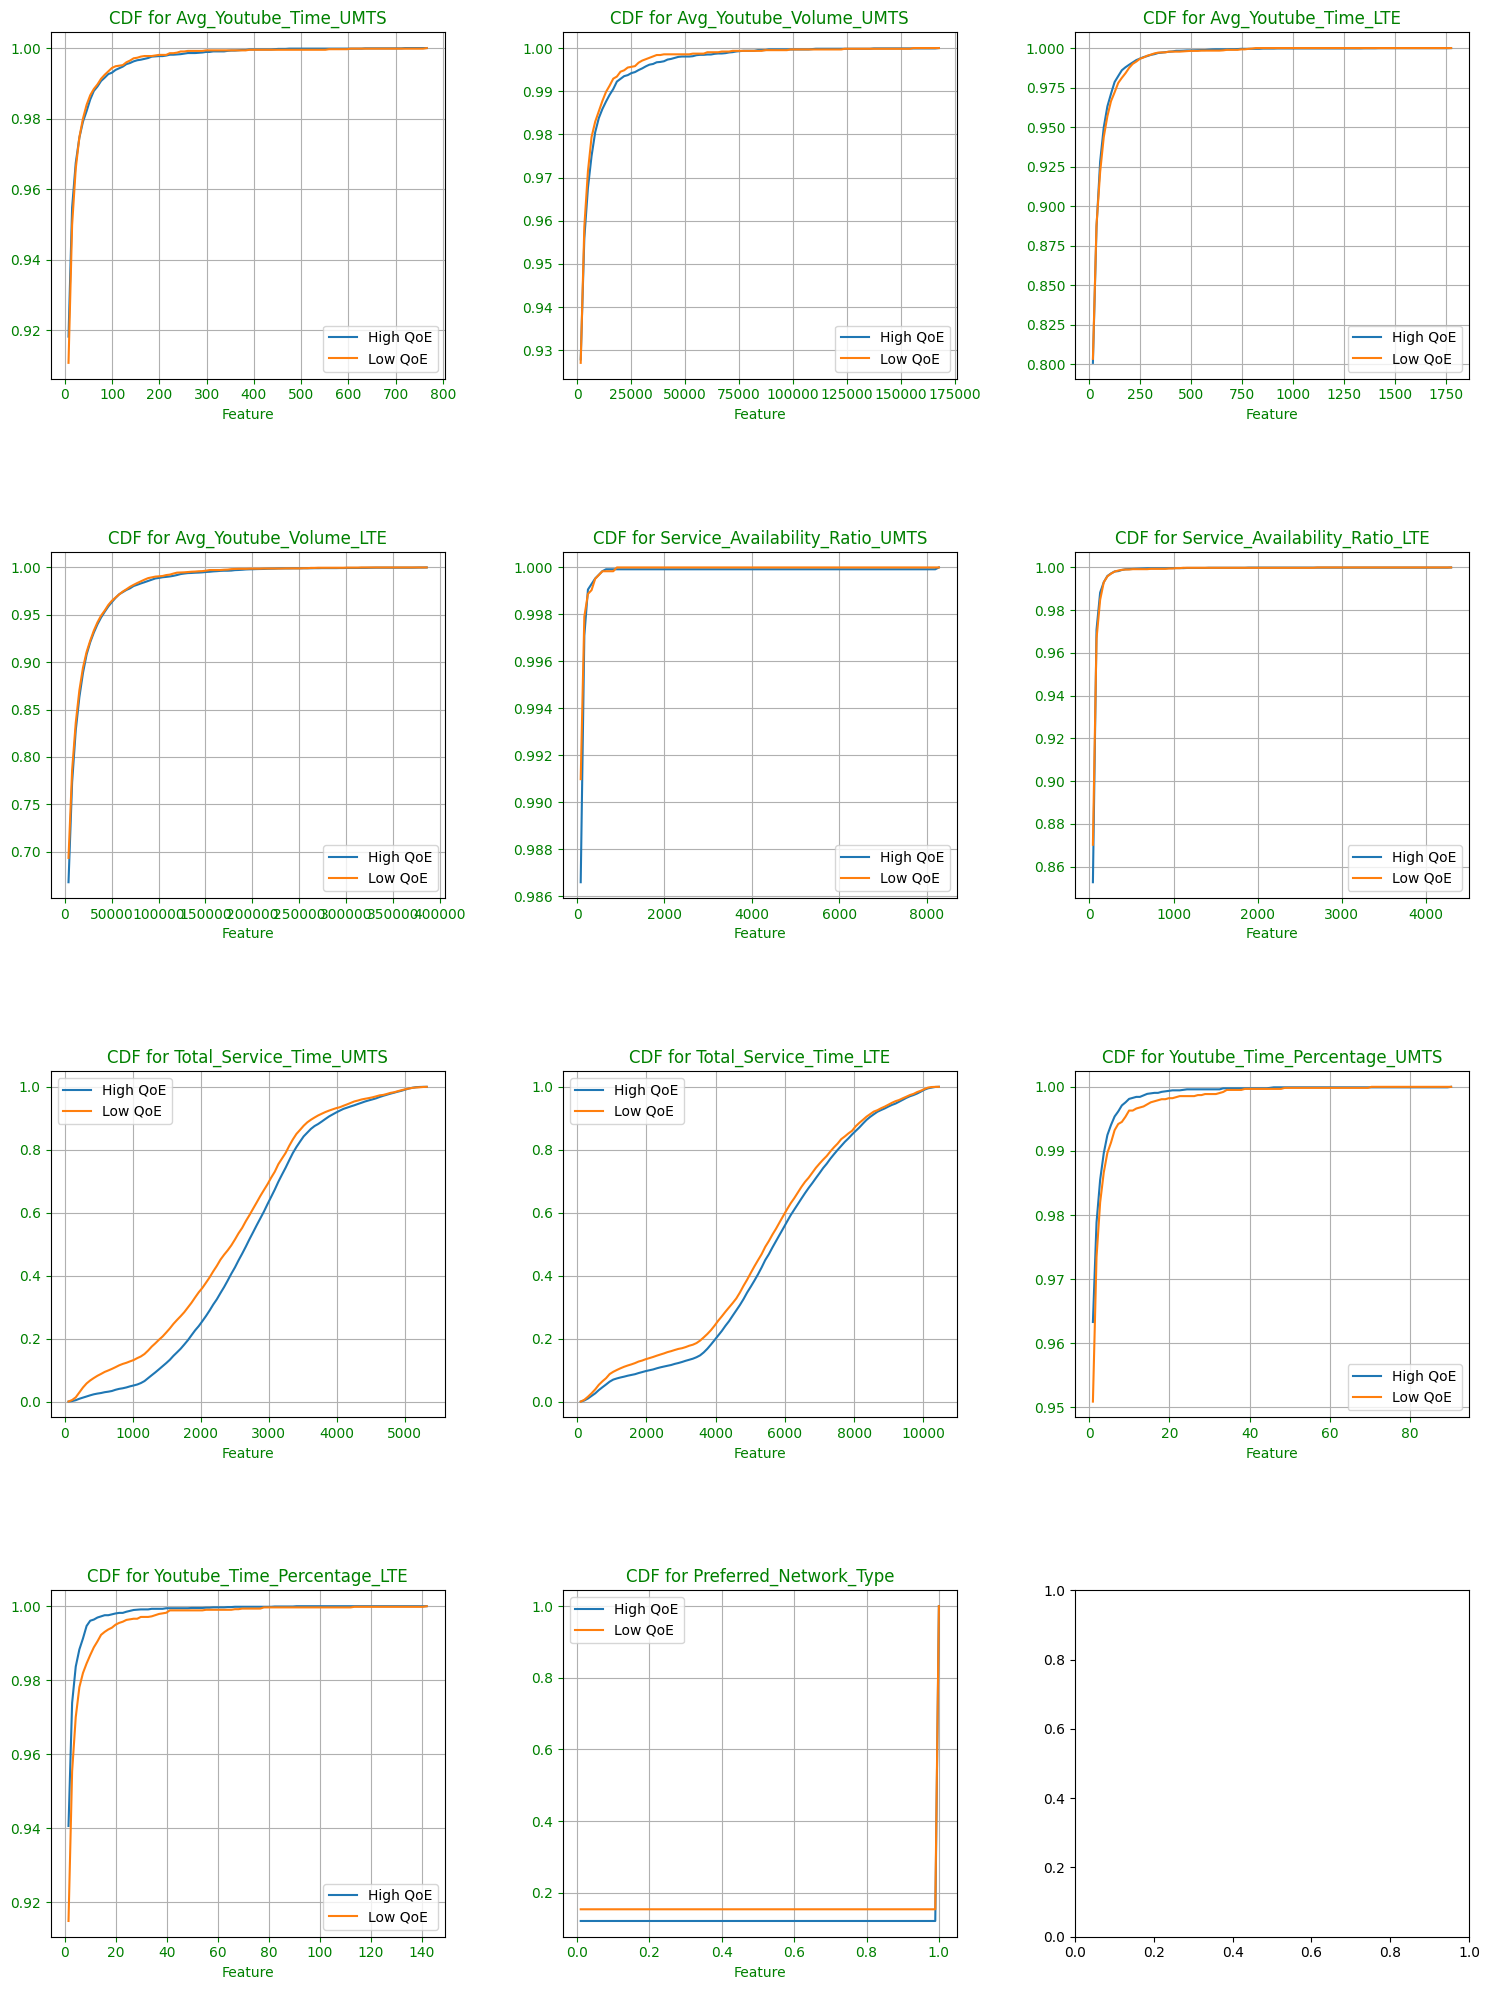

----------------------------------------
Features sorted by the gap between satisfied and unsatisfied user CDFs:
- Total_Service_Time_UMTS : 0.1072
- Total_Service_Time_LTE : 0.0477
- Preferred_Network_Type : 0.0326
- Avg_Youtube_Volume_LTE : 0.0257
- Youtube_Time_Percentage_LTE : 0.0257
- Service_Availability_Ratio_LTE : 0.0175
- Youtube_Time_Percentage_UMTS : 0.0124
- Avg_Youtube_Time_UMTS : 0.0074
- Avg_Youtube_Time_LTE : 0.0065
- Avg_Youtube_Volume_UMTS : 0.0044
- Service_Availability_Ratio_UMTS : 0.0044


In [ ]:
#Ploting CDF again to see if the new features (dataset2) are informative

data_features2 = ['Avg_Youtube_Time_UMTS', 'Avg_Youtube_Volume_UMTS',
       'Avg_Youtube_Time_LTE', 'Avg_Youtube_Volume_LTE',
       'Service_Availability_Ratio_UMTS', 'Service_Availability_Ratio_LTE',
       'Total_Service_Time_UMTS',
       'Total_Service_Time_LTE', 'Youtube_Time_Percentage_UMTS',
       'Youtube_Time_Percentage_LTE', 'Preferred_Network_Type']

sorted_features2 = plot_multiple_cdfs_sorted(dataset2, ground_truth, data_features2)

# Print the features based on the biggest gap to the lowest gap
print(40*"-")
print("Features sorted by the gap between satisfied and unsatisfied user CDFs:")
for feature, gap in sorted_features2:
    formatted_gap = "{:.4f}".format(gap)
    print("- {} : {}".format(feature, formatted_gap))

In [ ]:
# Dataset3 = dataset and dataset 2 are mixed together
dataset3 = pd.concat([dataset, dataset2], axis=1)
print(dataset3.shape)
print(40*"-")
print("The number of NaN values per each feature is: \n" + str(dataset3.isnull().sum()))
print(40*"-")
dataset3.head()

(18970, 23)
----------------------------------------
The number of NaN values per each feature is: 
Cumulative_YoutubeSess_LTE_DL_Time       0
Cumulative_YoutubeSess_LTE_DL_Volume     0
Cumulative_YoutubeSess_UMTS_DL_Time      0
Cumulative_YoutubeSess_UMTS_DL_Volume    0
Max_RSRQ                                 0
Max_SNR                                  0
Cumulative_Full_Service_Time_UMTS        0
Cumulative_Lim_Service_Time_UMTS         0
Cumulative_No_Service_Time_UMTS          0
Cumulative_Full_Service_Time_LTE         0
Cumulative_Lim_Service_Time_LTE          0
Cumulative_No_Service_Time_LTE           0
Avg_Youtube_Time_UMTS                    0
Avg_Youtube_Volume_UMTS                  0
Avg_Youtube_Time_LTE                     0
Avg_Youtube_Volume_LTE                   0
Service_Availability_Ratio_UMTS          0
Service_Availability_Ratio_LTE           0
Total_Service_Time_UMTS                  0
Total_Service_Time_LTE                   0
Youtube_Time_Percentage_UMTS            

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,...,Avg_Youtube_Volume_UMTS,Avg_Youtube_Time_LTE,Avg_Youtube_Volume_LTE,Service_Availability_Ratio_UMTS,Service_Availability_Ratio_LTE,Total_Service_Time_UMTS,Total_Service_Time_LTE,Youtube_Time_Percentage_UMTS,Youtube_Time_Percentage_LTE,Preferred_Network_Type
0,100.727,110854.0,0.000,0.0,-6.0,27.8,53917,5636,2043,213227,...,0.0,3.357567,3695.133333,7.021357,30.996802,2053.200000,7336.866667,0.000000,0.045763,1
1,9.324,93.0,0.000,0.0,-3.0,-19.8,85021,1761,1223,87700,...,0.0,0.310800,3.100000,28.492292,15.836042,2933.500000,3107.933333,0.000000,0.010000,1
2,2715.406,2271118.0,580.907,63891.0,-3.0,-19.8,123462,4664,2715,203846,...,2129.7,90.513533,75703.933333,16.731535,14.035114,4361.366667,7279.000000,0.443979,1.243489,1
3,74.097,39065.0,0.000,0.0,-4.0,-19.8,85675,4903,1322,7924,...,0.0,2.469900,1302.166667,13.763052,0.701860,3063.333333,640.466667,0.000000,0.385641,0
4,168.955,41933.0,0.000,0.0,-3.0,-19.9,104902,2068,669,137121,...,0.0,5.631833,1397.766667,38.327366,28.668409,3587.966667,4730.133333,0.000000,0.119063,1


In [ ]:
# Test_dataset3 = test_dataset and test_dataset2 are mixed together
test_dataset3 = pd.concat([test_dataset, test_dataset2], axis=1)
print(test_dataset3.shape)
print(40*"-")
print("The number of NaN values per each feature is: \n" + str(test_dataset3.isnull().sum()))
print(40*"-")
test_dataset3.head()

(4743, 23)
----------------------------------------
The number of NaN values per each feature is: 
Cumulative_YoutubeSess_LTE_DL_Time       0
Cumulative_YoutubeSess_LTE_DL_Volume     0
Cumulative_YoutubeSess_UMTS_DL_Time      0
Cumulative_YoutubeSess_UMTS_DL_Volume    0
Max_RSRQ                                 0
Max_SNR                                  0
Cumulative_Full_Service_Time_UMTS        0
Cumulative_Lim_Service_Time_UMTS         0
Cumulative_No_Service_Time_UMTS          0
Cumulative_Full_Service_Time_LTE         0
Cumulative_Lim_Service_Time_LTE          0
Cumulative_No_Service_Time_LTE           0
Avg_Youtube_Time_UMTS                    0
Avg_Youtube_Volume_UMTS                  0
Avg_Youtube_Time_LTE                     0
Avg_Youtube_Volume_LTE                   0
Service_Availability_Ratio_UMTS          0
Service_Availability_Ratio_LTE           0
Total_Service_Time_UMTS                  0
Total_Service_Time_LTE                   0
Youtube_Time_Percentage_UMTS             

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,...,Avg_Youtube_Volume_UMTS,Avg_Youtube_Time_LTE,Avg_Youtube_Volume_LTE,Service_Availability_Ratio_UMTS,Service_Availability_Ratio_LTE,Total_Service_Time_UMTS,Total_Service_Time_LTE,Youtube_Time_Percentage_UMTS,Youtube_Time_Percentage_LTE,Preferred_Network_Type
0,8.518,78.0,0.000,0.0,-3.0,23.2,57563,7008,1426,233812,...,0.000000,0.283933,2.600000,6.825113,18.586010,2199.900000,8213.066667,0.000000,0.003457,1
1,1006.045,199826.0,55.468,9946.0,-3.0,-19.8,93171,3051,674,235586,...,331.533333,33.534833,6660.866667,25.012349,24.000204,3229.866667,8180.066667,0.057245,0.409958,1
2,529.336,862215.0,157.434,59074.0,-6.0,26.6,99831,3154,4817,134049,...,1969.133333,17.644533,28740.500000,12.524275,29.487242,3593.400000,4619.833333,0.146040,0.381930,1
3,98.740,28225.0,0.000,0.0,-7.0,24.6,58229,1947,4566,152322,...,0.000000,3.291333,940.833333,8.940427,16.320797,2158.066667,5388.500000,0.000000,0.061081,1
4,3179.844,2055606.0,86.741,22218.0,-6.0,23.4,107891,5672,1048,138108,...,740.600000,105.994800,68520.200000,16.055208,18.615447,3820.366667,4850.900000,0.075683,2.185054,1


In [ ]:
#Dataset3 features sorted by the gap between satisfied and unsatisfied user CDF (Plots are already calculated in previous steps)

data_features3 = ['Cumulative_YoutubeSess_LTE_DL_Time',
       'Cumulative_YoutubeSess_LTE_DL_Volume',
       'Cumulative_YoutubeSess_UMTS_DL_Time',
       'Cumulative_YoutubeSess_UMTS_DL_Volume', 'Max_RSRQ', 'Max_SNR',
       'Cumulative_Full_Service_Time_UMTS', 'Cumulative_Lim_Service_Time_UMTS',
       'Cumulative_No_Service_Time_UMTS', 'Cumulative_Full_Service_Time_LTE',
       'Cumulative_Lim_Service_Time_LTE', 'Cumulative_No_Service_Time_LTE',
       'Avg_Youtube_Time_UMTS', 'Avg_Youtube_Volume_UMTS',
       'Avg_Youtube_Time_LTE', 'Avg_Youtube_Volume_LTE',
       'Service_Availability_Ratio_UMTS', 'Service_Availability_Ratio_LTE',
       'Total_Service_Time_UMTS',
       'Total_Service_Time_LTE', 'Youtube_Time_Percentage_UMTS',
       'Youtube_Time_Percentage_LTE', 'Preferred_Network_Type']

sorted_features3 = plot_multiple_cdfs_sorted(dataset3, ground_truth, data_features3,plot_flag=1)

# Print the features based on the biggest gap to the lowest gap
print(40*"-")
print("Features sorted by the gap between satisfied and unsatisfied user CDFs:")
for feature, gap in sorted_features3:
    formatted_gap = "{:.4f}".format(gap)
    print("- {} : {}".format(feature, formatted_gap))

----------------------------------------
Features sorted by the gap between satisfied and unsatisfied user CDFs:
- Cumulative_Full_Service_Time_UMTS : 0.1136
- Total_Service_Time_UMTS : 0.1072
- Cumulative_Lim_Service_Time_UMTS : 0.0852
- Max_SNR : 0.0683
- Cumulative_Full_Service_Time_LTE : 0.0507
- Total_Service_Time_LTE : 0.0477
- Max_RSRQ : 0.0451
- Cumulative_Lim_Service_Time_LTE : 0.0443
- Preferred_Network_Type : 0.0326
- Cumulative_YoutubeSess_LTE_DL_Volume : 0.0257
- Avg_Youtube_Volume_LTE : 0.0257
- Youtube_Time_Percentage_LTE : 0.0257
- Cumulative_No_Service_Time_UMTS : 0.0225
- Cumulative_No_Service_Time_LTE : 0.0197
- Service_Availability_Ratio_LTE : 0.0175
- Youtube_Time_Percentage_UMTS : 0.0124
- Cumulative_YoutubeSess_UMTS_DL_Time : 0.0074
- Avg_Youtube_Time_UMTS : 0.0074
- Cumulative_YoutubeSess_LTE_DL_Time : 0.0065
- Avg_Youtube_Time_LTE : 0.0065
- Cumulative_YoutubeSess_UMTS_DL_Volume : 0.0044
- Avg_Youtube_Volume_UMTS : 0.0044
- Service_Availability_Ratio_UMTS : 0.0

In [ ]:
# Feature Ranking using XGBoost and Hyperparameter Tuning with Bayesian Optimization
# -------------------------------------------------------------------------
# The following steps are performed:

# 1. Feature Ranking with XGBoost:
#    XGBoost, a powerful gradient boosting algorithm, is employed to rank the importance of features in the dataset.
#    This process aids in identifying which features have the most influence on the target variable.
#    The feature ranking results can be used for feature selection or interpretation.

# 2. Hyperparameter Tuning with Bayesian Optimization:
#    Hyperparameters greatly influence the performance of machine learning models.
#    Bayesian Optimization is employed to efficiently search the hyperparameter space of the XGBoost classifier.
#    By intelligently selecting hyperparameters, we aim to improve the model's predictive capability.


In [ ]:
pip install xgboost

In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV

In [ ]:
def train_and_get_feature_importance(X_train, y_train):
    # Define a parameter space with the hyperparameter ranges to search over
    param_space = {
        'max_depth': (5, 10, 15),
        'learning_rate': (0.001, 0.1, 'log-uniform'),
        'n_estimators': (100, 300)
    }

    # Create the XGBoost model
    model = XGBClassifier()

    # Perform Bayesian optimization
    bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, n_iter=10)
    bayes_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params_feature_selection = bayes_search.best_params_

    # Store the feature names
    feature_names = X_train.columns

    # Create the final XGBoost model with the best hyperparameters
    final_model = XGBClassifier(**best_params_feature_selection)

    # Train the final model on the entire training dataset
    final_model.fit(X_train, y_train)

    # Get feature importance scores
    feature_importance = final_model.feature_importances_

    # Sort feature importance scores and feature names based on importance scores
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    return sorted_importance, sorted_feature_names, best_params_feature_selection


def plot_feature_importance(dataset_name, sorted_importance, sorted_feature_names, best_params):
    # Plotting the bar plot
    plt.figure(figsize=(8, 6))

    # Create the bar plot using Matplotlib
    plt.bar(range(len(sorted_importance)), sorted_importance, tick_label=sorted_feature_names)

    # Rotating the x-axis labels for better visibility
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)

    # Adding labels and title
    plt.xlabel('Feature Names')
    plt.ylabel('Importance Score')
    plt.title(f'Feature Importance Scores for {dataset_name} Dataset')

    # Show the plot
    plt.tight_layout()  # To make sure labels are not cut off
    plt.show()

    print(40*"-")
    print(f"Best Hyperparameters for {dataset_name} :", best_params)
    print(40*"-")
    print(f"The most important features in {dataset_name}  are:\n")
    print('\n'.join(sorted_feature_names))

In [ ]:
X = dataset
y = ground_truth
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sorted_importance, sorted_feature_names, best_params_selected = train_and_get_feature_importance(X_train, y_train)

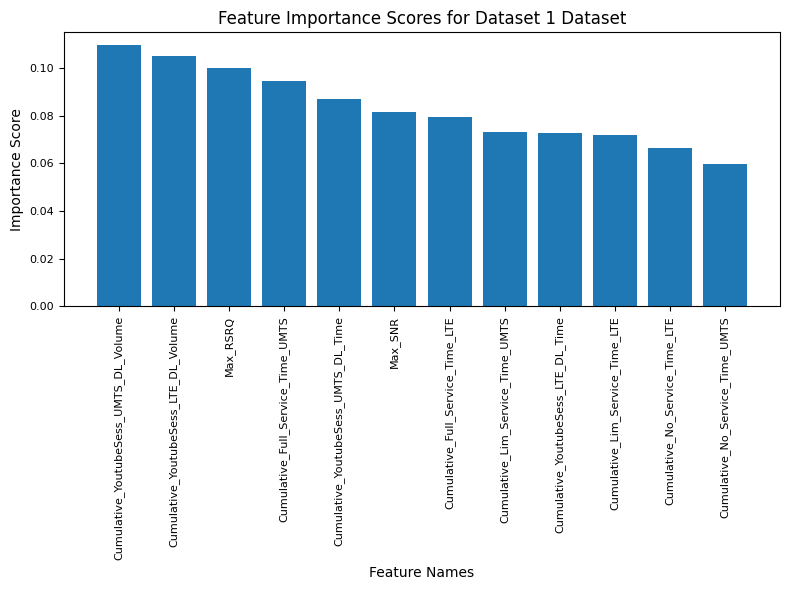

----------------------------------------
Best Hyperparameters for Dataset 1 : OrderedDict([('learning_rate', 0.015622374617676725), ('max_depth', 10), ('n_estimators', 220)])
----------------------------------------
The most important features in Dataset 1  are:

Cumulative_YoutubeSess_UMTS_DL_Volume
Cumulative_YoutubeSess_LTE_DL_Volume
Max_RSRQ
Cumulative_Full_Service_Time_UMTS
Cumulative_YoutubeSess_UMTS_DL_Time
Max_SNR
Cumulative_Full_Service_Time_LTE
Cumulative_Lim_Service_Time_UMTS
Cumulative_YoutubeSess_LTE_DL_Time
Cumulative_Lim_Service_Time_LTE
Cumulative_No_Service_Time_LTE
Cumulative_No_Service_Time_UMTS


In [ ]:
plot_feature_importance('Dataset 1', sorted_importance, sorted_feature_names, best_params_selected)

In [ ]:
# XGBOOST for dataset2 (generated in feature engineering part)
X = dataset2
y = ground_truth
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sorted_importance2, sorted_feature_names2, best_params_selected2 = train_and_get_feature_importance(X_train, y_train)

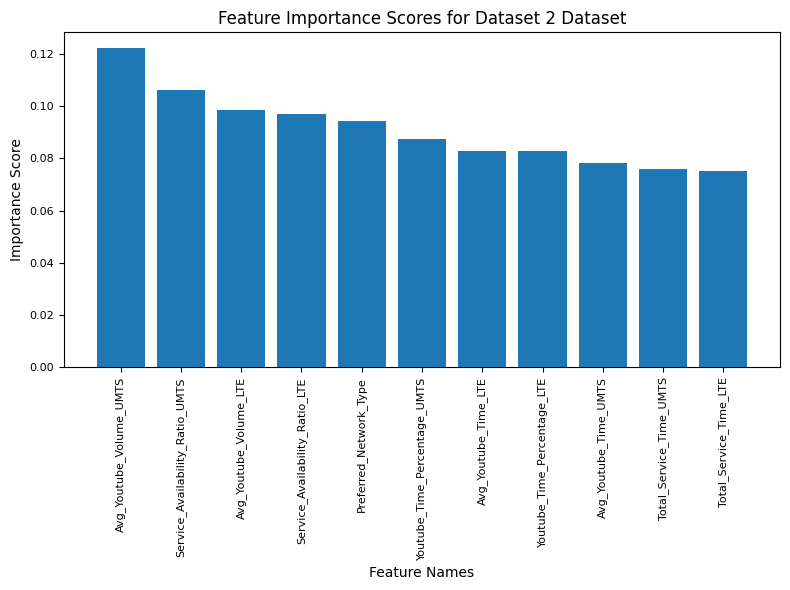

----------------------------------------
Best Hyperparameters for Dataset 2 : OrderedDict([('learning_rate', 0.09820379570722293), ('max_depth', 10), ('n_estimators', 127)])
----------------------------------------
The most important features in Dataset 2  are:

Avg_Youtube_Volume_UMTS
Service_Availability_Ratio_UMTS
Avg_Youtube_Volume_LTE
Service_Availability_Ratio_LTE
Preferred_Network_Type
Youtube_Time_Percentage_UMTS
Avg_Youtube_Time_LTE
Youtube_Time_Percentage_LTE
Avg_Youtube_Time_UMTS
Total_Service_Time_UMTS
Total_Service_Time_LTE


In [ ]:
plot_feature_importance('Dataset 2', sorted_importance2, sorted_feature_names2, best_params_selected2)

In [ ]:
#XGBOOST for Dataset 3
X = dataset3
y = ground_truth
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sorted_importance3, sorted_feature_names3, best_params_selected3 = train_and_get_feature_importance(X_train, y_train)

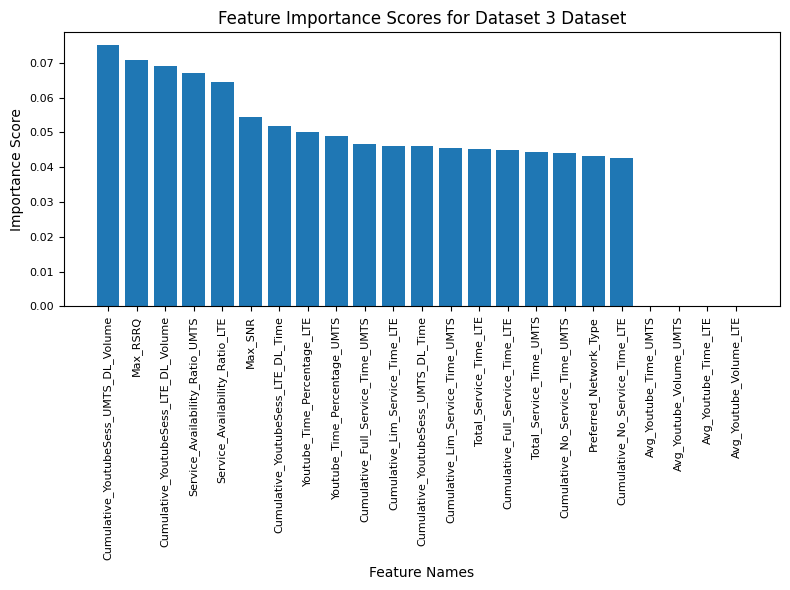

----------------------------------------
Best Hyperparameters for Dataset 3 : OrderedDict([('learning_rate', 0.04107620347292034), ('max_depth', 15), ('n_estimators', 265)])
----------------------------------------
The most important features in Dataset 3  are:

Cumulative_YoutubeSess_UMTS_DL_Volume
Max_RSRQ
Cumulative_YoutubeSess_LTE_DL_Volume
Service_Availability_Ratio_UMTS
Service_Availability_Ratio_LTE
Max_SNR
Cumulative_YoutubeSess_LTE_DL_Time
Youtube_Time_Percentage_LTE
Youtube_Time_Percentage_UMTS
Cumulative_Full_Service_Time_UMTS
Cumulative_Lim_Service_Time_LTE
Cumulative_YoutubeSess_UMTS_DL_Time
Cumulative_Lim_Service_Time_UMTS
Total_Service_Time_LTE
Cumulative_Full_Service_Time_LTE
Total_Service_Time_UMTS
Cumulative_No_Service_Time_UMTS
Preferred_Network_Type
Cumulative_No_Service_Time_LTE
Avg_Youtube_Time_UMTS
Avg_Youtube_Volume_UMTS
Avg_Youtube_Time_LTE
Avg_Youtube_Volume_LTE


In [ ]:
plot_feature_importance('Dataset 3', sorted_importance3, sorted_feature_names3, best_params_selected3)

# Prediction Pipeline

## Select ML Classifiers, HP Candidate Values and K-Fold Validation Structure

In [ ]:
# Define the hyperparameter space for different classifiers
hyperparameters_space = {
    'Random Forest': {
        'n_estimators': (20, 40, 50),
        'max_depth': (10, 20, 30)
    },
    'XGBoost': {
        'n_estimators': (35, 45, 55),
        'max_depth': (1, 10, 20),
        'learning_rate': (0.001, 0.005, 0.01)
    },
    'Decision Tree': {
        'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    }
}


In [ ]:
X_train_1 = dataset
X_train_2 = dataset2
X_train_3 = dataset3
y_train_1 = ground_truth
y_train_2 = ground_truth
y_train_3 = ground_truth

X_test_1 = test_dataset
X_test_2 = test_dataset2
X_test_3 = test_dataset3
y_test_1 = test_ground_truth
y_test_2 = test_ground_truth
y_test_3 = test_ground_truth

# Step 2: Define ML classifiers and hyperparameter search space
classifiers = {
    'XGBoost': XGBClassifier(subsample=0.8),
    'Random Forest': RandomForestClassifier(class_weight="balanced"),
    'Decision Tree': DecisionTreeClassifier(class_weight = "balanced")
}

## Tune ML Classifiers through a K-Fold Validation

Columns of train and test are equal - dataset 1.
Training XGBoost - Dataset 1 is started
------------------------------------------------------------

Fitting 5 folds for each of 27 candidates, totalling 135 fits


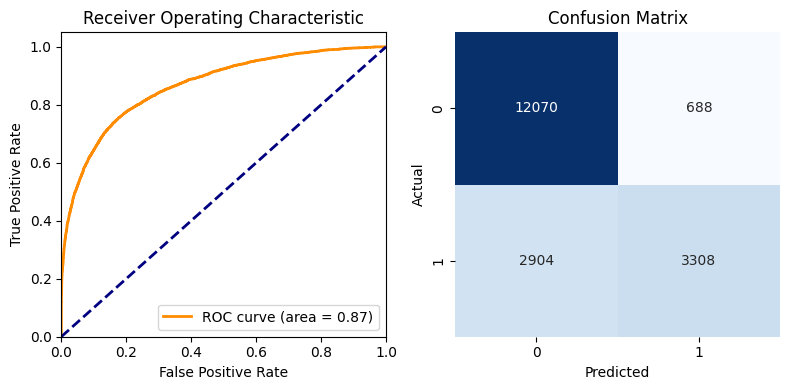


Saved XGBoost model for Dataset 1 as XGBoost_Dataset 1_model.pkl
Training XGBoost - Dataset 1 is done
Time taken: 5 minutes and 52.2 seconds
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 55}
************************************************************

Training Random Forest - Dataset 1 is started
------------------------------------------------------------

Fitting 5 folds for each of 9 candidates, totalling 45 fits


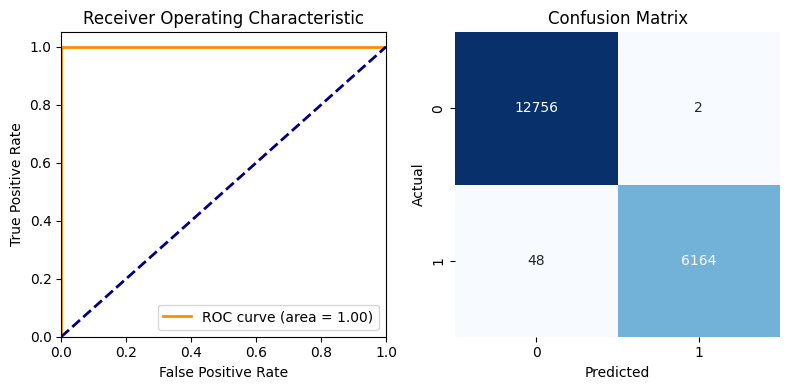


Saved Random Forest model for Dataset 1 as Random Forest_Dataset 1_model.pkl
Training Random Forest - Dataset 1 is done
Time taken: 1 minutes and 9.8 seconds
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 50}
************************************************************

Training Decision Tree - Dataset 1 is started
------------------------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits


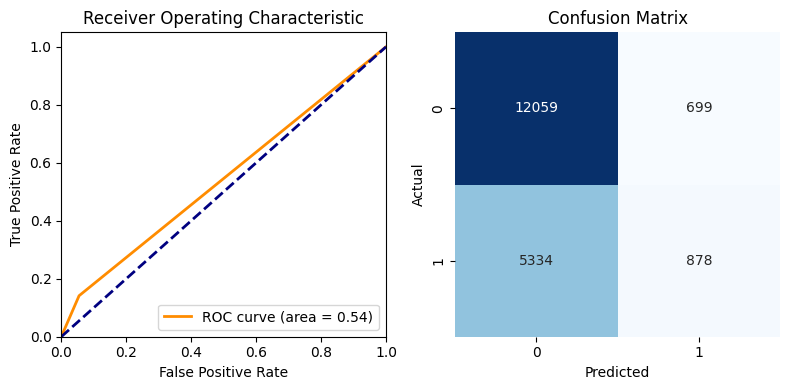


Saved Decision Tree model for Dataset 1 as Decision Tree_Dataset 1_model.pkl
Training Decision Tree - Dataset 1 is done
Time taken: 5.2 seconds
Best Hyperparameters: {'max_depth': 1}
************************************************************

Columns of train and test are equal - dataset 2.
Training XGBoost - Dataset 2 is started
------------------------------------------------------------

Fitting 5 folds for each of 27 candidates, totalling 135 fits


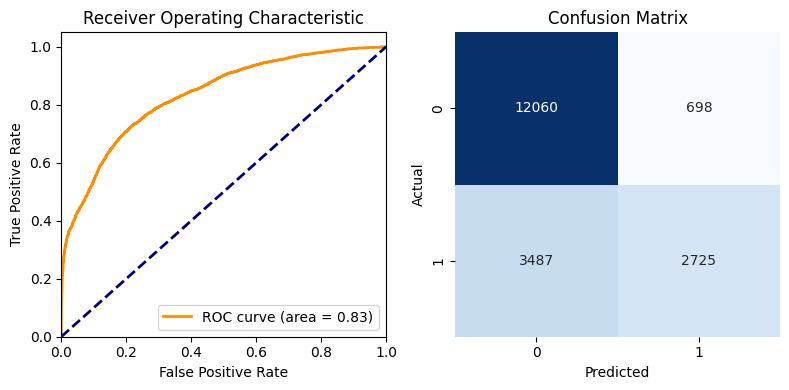


Saved XGBoost model for Dataset 2 as XGBoost_Dataset 2_model.pkl
Training XGBoost - Dataset 2 is done
Time taken: 5 minutes and 29.5 seconds
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 55}
************************************************************

Training Random Forest - Dataset 2 is started
------------------------------------------------------------

Fitting 5 folds for each of 9 candidates, totalling 45 fits


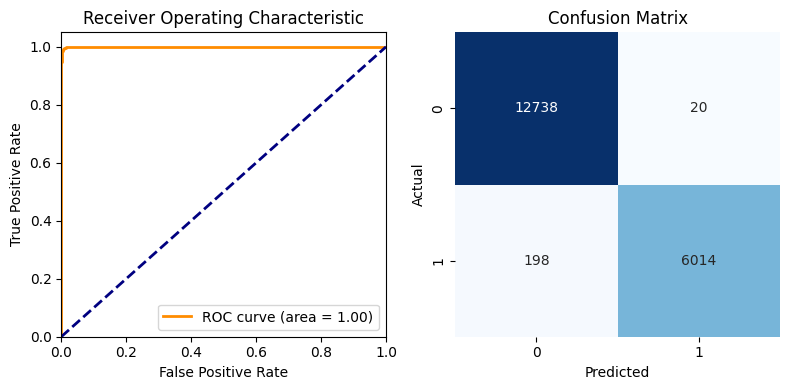


Saved Random Forest model for Dataset 2 as Random Forest_Dataset 2_model.pkl
Training Random Forest - Dataset 2 is done
Time taken: 1 minutes and 11.0 seconds
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 50}
************************************************************

Training Decision Tree - Dataset 2 is started
------------------------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits


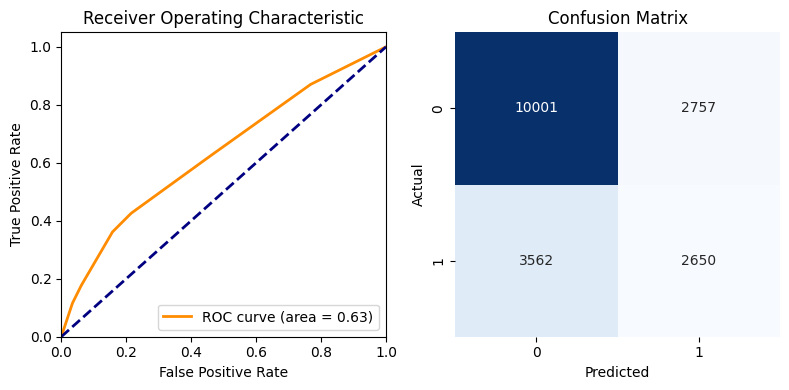


Saved Decision Tree model for Dataset 2 as Decision Tree_Dataset 2_model.pkl
Training Decision Tree - Dataset 2 is done
Time taken: 5.2 seconds
Best Hyperparameters: {'max_depth': 3}
************************************************************

Columns of train and test are equal - dataset 3.
Training XGBoost - Dataset 3 is started
------------------------------------------------------------

Fitting 5 folds for each of 27 candidates, totalling 135 fits


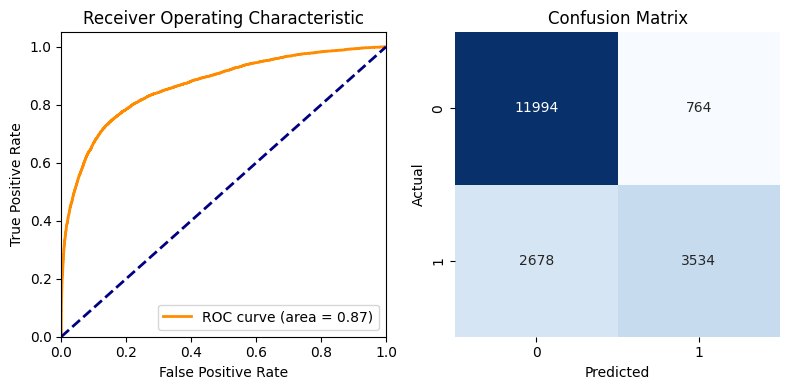


Saved XGBoost model for Dataset 3 as XGBoost_Dataset 3_model.pkl
Training XGBoost - Dataset 3 is done
Time taken: 10 minutes and 2.7 seconds
Best Hyperparameters: {'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 55}
************************************************************

Training Random Forest - Dataset 3 is started
------------------------------------------------------------

Fitting 5 folds for each of 9 candidates, totalling 45 fits


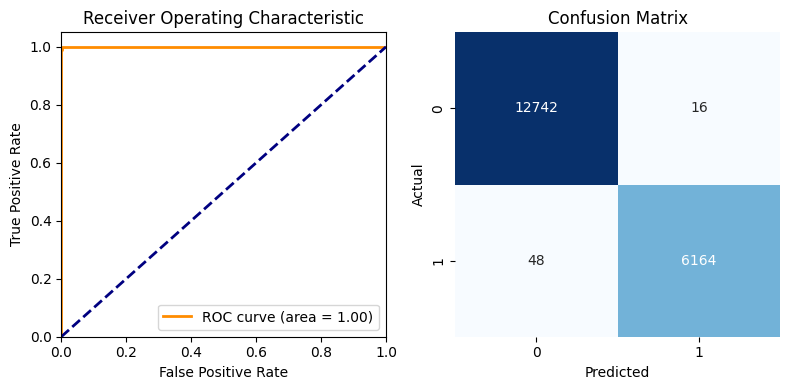


Saved Random Forest model for Dataset 3 as Random Forest_Dataset 3_model.pkl
Training Random Forest - Dataset 3 is done
Time taken: 1 minutes and 31.9 seconds
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 50}
************************************************************

Training Decision Tree - Dataset 3 is started
------------------------------------------------------------

Fitting 5 folds for each of 10 candidates, totalling 50 fits


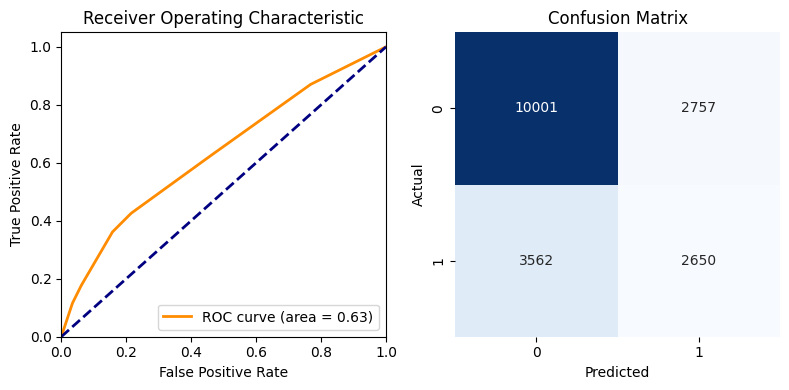


Saved Decision Tree model for Dataset 3 as Decision Tree_Dataset 3_model.pkl
Training Decision Tree - Dataset 3 is done
Time taken: 10.5 seconds
Best Hyperparameters: {'max_depth': 3}
************************************************************



In [ ]:
# Step 3: Set up K-Fold Validation structure
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Step 4: Train and tune models on each dataset using Bayesian optimization

datasets = [(X_train_1, y_train_1), (X_train_2, y_train_2), (X_train_3, y_train_3)]
dataset_names = ['Dataset 1', 'Dataset 2', 'Dataset 3']
best_hyperparameters = {}
results_per_dataset = {}
warnings.filterwarnings("ignore")

scaler = StandardScaler()
scaler_dict = {}

for dataset_idx, (X_train, y_train) in enumerate(datasets):
    dataset_name = dataset_names[dataset_idx]

    # Normalize training data using the selected scaler
    scaler = StandardScaler()  # Initialize a new scaler for each dataset
    if X_train.columns.equals(X_test_1.columns):
      print("Columns of train and test are equal - dataset 1.")
    if X_train.columns.equals(X_test_2.columns):
      print("Columns of train and test are equal - dataset 2.")
    if X_train.columns.equals(X_test_3.columns):
      print ("Columns of train and test are equal - dataset 3.")
    X_train_normalized = scaler.fit_transform(X_train)  # Fit and transform X_train

    # Store the scaler in the dictionary
    scaler_dict[dataset_name] = scaler

    for name, clf in classifiers.items():
        start_time = time.time()
        print(f"Training {name} - {dataset_name} is started")
        print(60*"-"+ "\n")

        grid_search = GridSearchCV(clf, hyperparameters_space[name], cv=kf, n_jobs=-1, verbose=10)
        grid_search.fit(X_train_normalized, y_train)

        clf_tuned = clf.set_params(**grid_search.best_params_)
        clf_tuned.fit(X_train_normalized, y_train)

        # Train the model on the entire dataset
        clf_tuned.fit(X_train_normalized, y_train)

        # Predict probabilities for ROC curve
        y_pred_probs = clf_tuned.predict_proba(X_train_normalized)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_train, y_pred_probs)
        roc_auc = auc(fpr, tpr)

        # Generate confusion matrix (numerical)
        y_pred = clf_tuned.predict(X_train_normalized)
        cm = confusion_matrix(y_train, y_pred)

        # Plot ROC curve and confusion matrix
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")

        plt.subplot(1, 2, 2)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.tight_layout()
        plt.show()

        end_time = time.time()

        # Save the trained model to disk
        model_filename = f"{name}_{dataset_name}_model.pkl"
        joblib.dump(clf_tuned, model_filename)
        print()
        print(f"Saved {name} model for {dataset_name} as {model_filename}")

        elapsed_time = end_time - start_time
        print(f"Training {name} - {dataset_name} is done")
        if elapsed_time < 60:
            print(f"Time taken: {elapsed_time:.1f} seconds")
        else:
            minutes = int(elapsed_time // 60)
            seconds = elapsed_time % 60
            print(f"Time taken: {minutes} minutes and {seconds:.1f} seconds")
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(60*"*" + "\n")

## Evaluate Performance on Test Set, where each ML Classifier work with best HP Values

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, dataset_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Generate confusion matrix (numerical)
    cm = confusion_matrix(y_test, y_pred)

    # Plot ROC curve and confusion matrix
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Print results
    print(f"Model: {model_name}, Dataset: {dataset_name}")
    print("-" * 60)



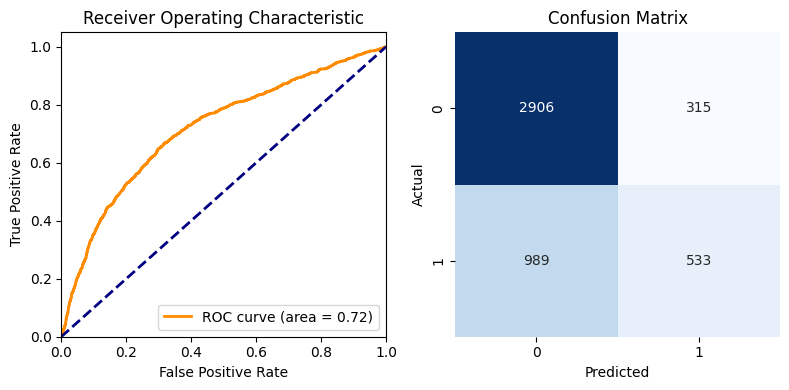

Model: Random Forest, Dataset: Dataset 1
------------------------------------------------------------


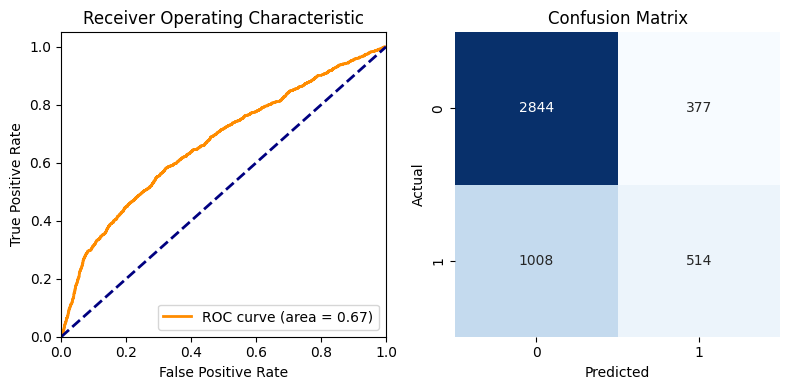

Model: Random Forest, Dataset: Dataset 2
------------------------------------------------------------


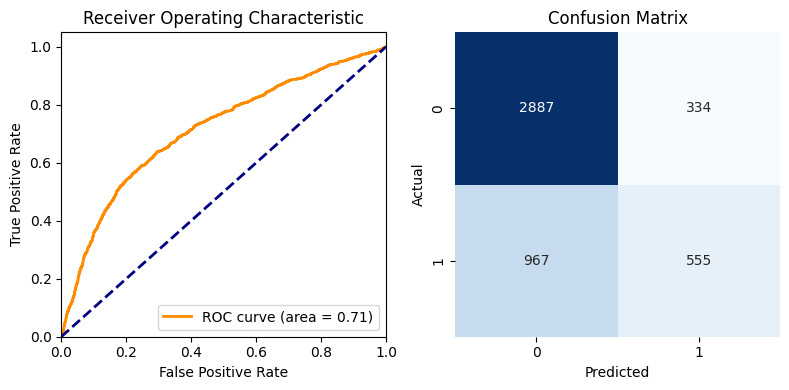

Model: Random Forest, Dataset: Dataset 3
------------------------------------------------------------


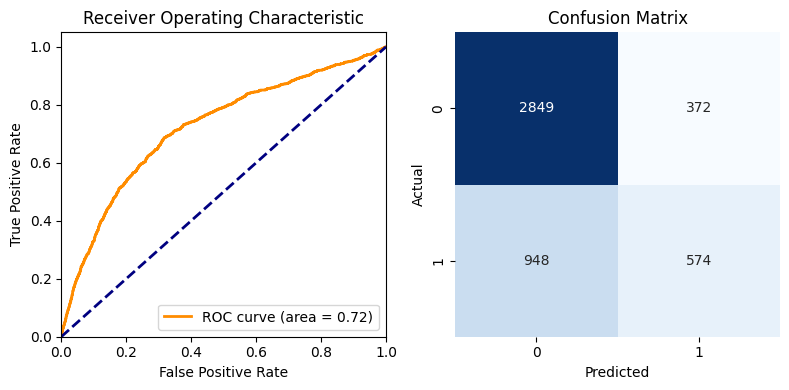

Model: XGBoost, Dataset: Dataset 1
------------------------------------------------------------


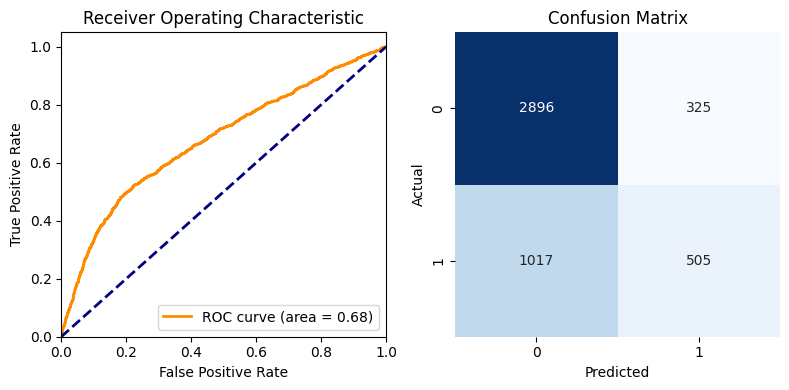

Model: XGBoost, Dataset: Dataset 2
------------------------------------------------------------


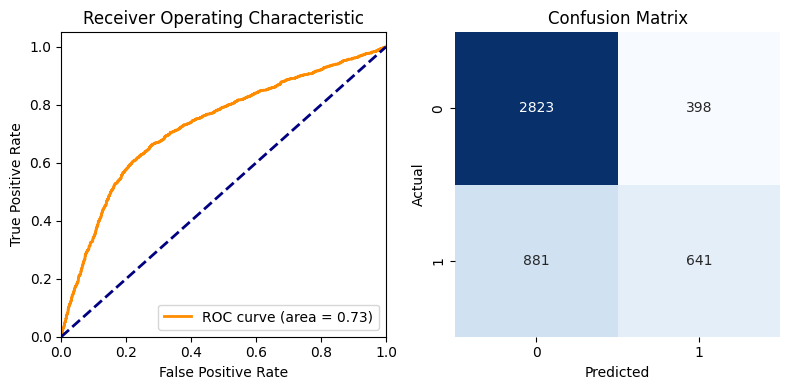

Model: XGBoost, Dataset: Dataset 3
------------------------------------------------------------


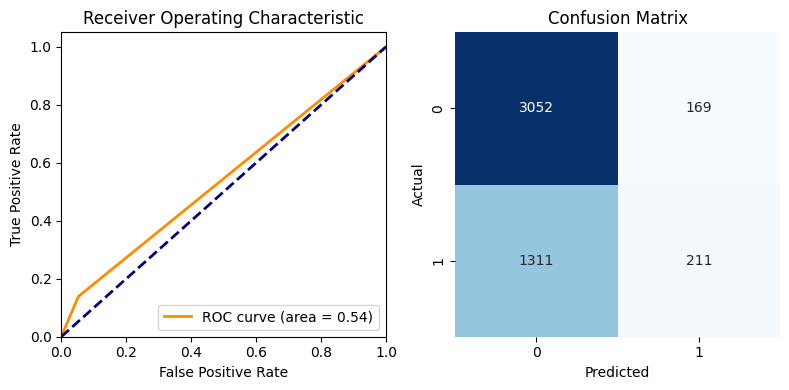

Model: Decision Tree, Dataset: Dataset 1
------------------------------------------------------------


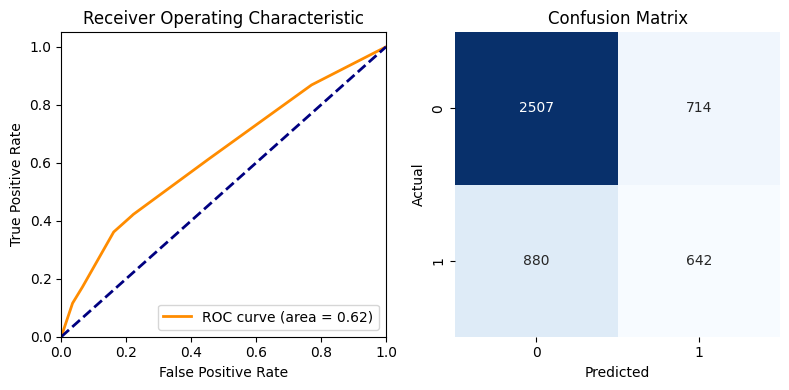

Model: Decision Tree, Dataset: Dataset 2
------------------------------------------------------------


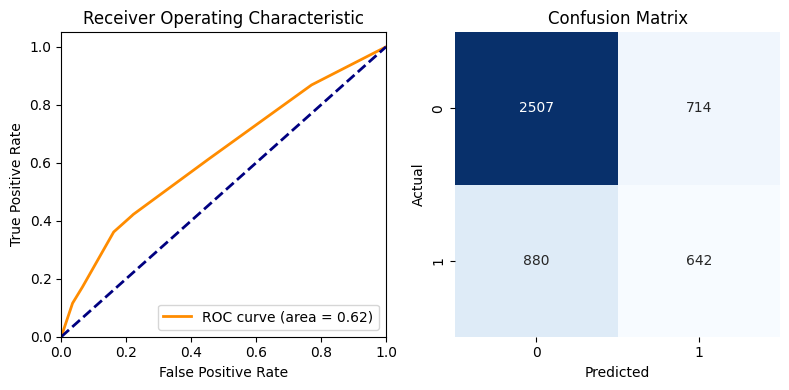

Model: Decision Tree, Dataset: Dataset 3
------------------------------------------------------------


In [ ]:
# Step 1: Normalize the datasets
X_test_1_normalized = scaler_dict['Dataset 1'].transform(X_test_1)
X_test_2_normalized = scaler_dict['Dataset 2'].transform(X_test_2)
X_test_3_normalized = scaler_dict['Dataset 3'].transform(X_test_3)

# List of model names and dataset names
model_names_test = ['Random Forest','XGBoost', 'Decision Tree']
dataset_names_test = ['Dataset 1', 'Dataset 2', 'Dataset 3']
y_test_datasets = [y_test_1, y_test_2, y_test_3]

# Dictionary mapping model and dataset combinations to corresponding X datasets
X_datasets = {
    ('XGBoost', 'Dataset 1'): X_test_1_normalized,
    ('XGBoost', 'Dataset 2'): X_test_2_normalized,
    ('XGBoost', 'Dataset 3'): X_test_3_normalized,
    ('Random Forest', 'Dataset 1'): X_test_1_normalized,
    ('Random Forest', 'Dataset 2'): X_test_2_normalized,
    ('Random Forest', 'Dataset 3'): X_test_3_normalized,
    ('Decision Tree', 'Dataset 1'): X_test_1_normalized,
    ('Decision Tree', 'Dataset 2'): X_test_2_normalized,
    ('Decision Tree', 'Dataset 3'): X_test_3_normalized,
}

# Load and evaluate models
for model_name in model_names_test:
    for dataset_name, y_test in zip(dataset_names_test, y_test_datasets):
        model_filename = f"{model_name}_{dataset_name}_model.pkl"
        clf = joblib.load(model_filename)

        # Get the corresponding X dataset from the dictionary
        X_test = X_datasets[(model_name, dataset_name)]

        evaluate_model(clf, X_test, y_test, model_name, dataset_name)